In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Predict Sequence length : 12H

Epoch 1 Test Loss 1.7770
Time taken for 1 epoch: 3.7781436443328857 secs

Epoch 2 Test Loss 1.7770
Time taken for 1 epoch: 0.031503915786743164 secs

Epoch 3 Test Loss 1.7727
Time taken for 1 epoch: 0.03075265884399414 secs

Epoch 4 Test Loss 1.7641
Time taken for 1 epoch: 0.0313565731048584 secs

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Epoch 5 Test Loss 1.7511
Time taken for 1 epoch: 0.11915946006774902 secs

Epoch 6 Test Loss 1.7338
Time taken for 1 epoch: 0.029265880584716797 secs

Epoch 7 Test Loss 1.7122
Time taken for 1 epoch: 0.02947235107421875 secs

Epoch 8 Test Loss 1.6864
Time taken for 1 epoch: 0.02913045883178711 secs

Epoch 9 Test Loss 1.6562
Time taken for 1 epoch: 0.028739213943481445 secs

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Epoch 10 Test Loss 1.6249
Time taken for 1 epoch: 0.09090852737426758 secs

Epoch 11 Test Loss 1.5950
Time taken for 1 epoch: 0.028684139251708984 secs

Epoch 12 Test Loss 1.5631
Time taken for 1 epoch: 

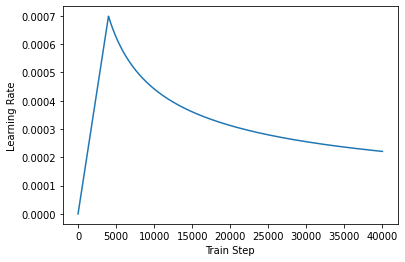

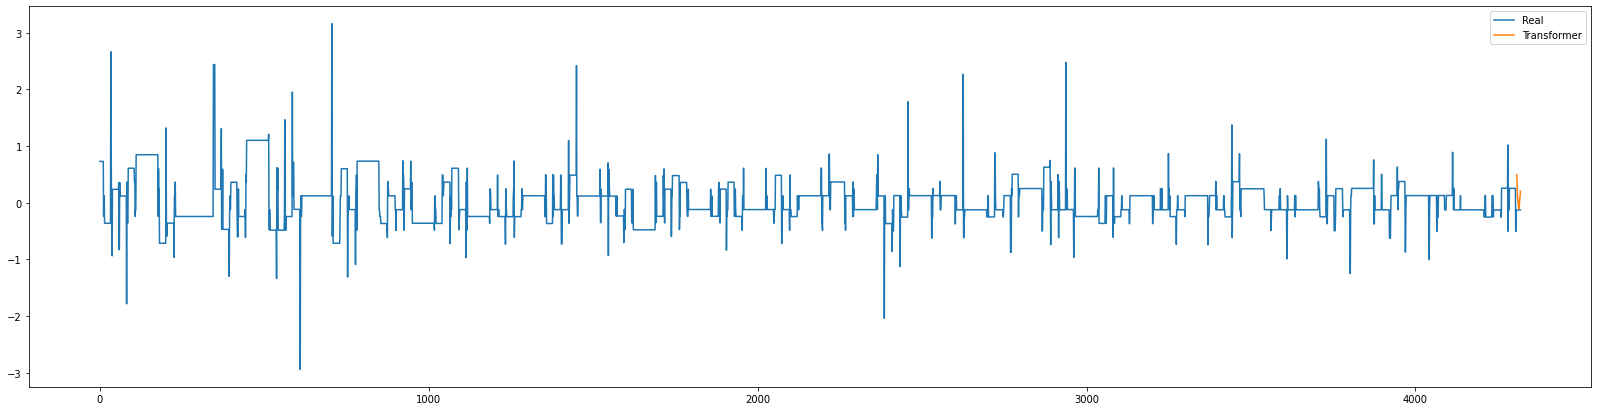

Transformer
----------------------------------------
MSE: 0.08130421489477158 |
MAE : 0.22178857028484344
Transformer 모델이 동작하는 시간 : 19.863006114959717



In [2]:
# informer, ARIMA, Prophet, LSTMa와는 다른 형식의 CSV를 사용한다.(Version2)

# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version2.csv', encoding='cp949')
df.head()

data_start_date = df.columns[1]
data_end_date = df.columns[-1]

######################## CHECK #########################


from datetime import timedelta

pred_steps = 12+23
pred_length=timedelta(hours = pred_steps)

first_day = pd.to_datetime(data_start_date)
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day


train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)


enc_length = train_pred_start - first_day


train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

#np.log 1p 해준다.

date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values.astype(np.float32)

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1)
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))

    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))    
    
    return series_array

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)


encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)


encoder_input_val_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_val_data, encode_series_mean = transform_series_encode(encoder_input_val_data)

decoder_target_val_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_val_data = transform_series_decode(decoder_target_val_data, encode_series_mean)

!pip install tensorflow_datasets

import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_target_data))
val_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_val_data, decoder_target_val_data))

### position
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

# Masking
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions so that we can add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 4))
temp = create_look_ahead_mask(x.shape[1])

# Scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.
  
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth)
        mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_v, depth)

    return output, attention_weights


# Multi Head Attention

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v) # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size) #(batch_size, num_head, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_v, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_v, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_v, d_model)
        
        return output, attention_weights
    

# Point wise feed forward network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


# Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)
        
        return out2


# Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
                                            
    def call(self, x, enc_output, training,
            look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

# Encoder

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000,
                rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding
        x = self.embedding(x)
        # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x


# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training,
                look_ahead_mask, padding_mask):
        
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                  look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        
        
        return x, attention_weights
    


class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, out_dim, max_len=5000,
                rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                              max_len, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               max_len, rate)
        
        self.final_layer = tf.keras.layers.Dense(out_dim)
        
    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights


# Set hyperparameters
# 트랜스포머 기준으로 바꿔볼까? 
# d_model – the number of expected features in the encoder/decoder inputs (default=512).
# nhead – the number of heads in the multiheadattention models (default=8).
# num_encoder_layers – the number of sub-encoder-layers in the encoder & decoder (default=6).
# num_decoder_layers – the number of sub-decoder-layers in the decoder (default=6).
# dff(dim_feedforward) – the dimension of the feedforward network model (default=2048).
# dropout – the dropout value (default=0.1).


num_layers = 1
d_model = 64
dff = 256
num_heads = 4

dropout_rate = 0.1
input_sequence_length = 4320-(12+23) # Length of the sequence used by the encoder
target_sequence_length = 12+23 # Length of the sequence predicted by the decoder
batch_size = 2**11

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Optimizizer
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(64)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and metrics
loss_object = tf.keras.losses.MeanAbsoluteError()

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name='train_loss')
#train_accuracy = tf.keras.metrics.mean_absolute_error()

test_loss = tf.keras.metrics.Mean(name='test_loss')

# Training and checkpoint
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          out_dim=1, rate=dropout_rate)

def create_masks(inp, tar):
    inp = inp.reshape()
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

# check point
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    
# EPOCHS
EPOCHS=100

@tf.function
def train_step(inp, tar):
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
  
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    #train_accuracy(tar_real, predictions)

@tf.function
def test_step(inp, tar):

    last_inp = tf.expand_dims(inp[:,0,:],-1)

    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     False, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    test_loss(loss)

# Val_dataset을 돌려서 Val_prediction 구간을 예측한다

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    test_loss.reset_states()
    
    # validation:
    for (batch, (inp, tar)) in enumerate(val_dataset):
        #print(inp, tar)
        test_step(inp, tar)
        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    print ('Epoch {} Test Loss {:.4f}'.format(epoch + 1, 
                                                test_loss.result())) 
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    
MAX_LENGTH = target_sequence_length

def evaluate(inp):
    encoder_input = inp
    #print(encoder_input)
    output = tf.expand_dims(encoder_input[:,-1,:],-1)
    #print(output)
    
    for i in range(MAX_LENGTH):
        look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
        predictions, attention_weights = transformer(encoder_input, 
                                                     output, 
                                                     False, 
                                                     None, 
                                                     look_ahead_mask, 
                                                     None)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1)
        #print("pred:", predictions) #
        output = tf.concat([output, predictions], axis=1)
        #print(output)
        
    return tf.squeeze(output, axis=0), attention_weights

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

encode_series = encoder_input_val_data[0:1,:,:] 
#print(encode_series)

pred_series, _ = evaluate(encode_series)
pred_series = np.array([pred_series])
encode_series_12 = encode_series.reshape(-1,1)
pred_series_12 = pred_series.reshape(-1,1)[1:,:]   
target_series_12 = decoder_target_val_data[0,:,:1].reshape(-1,1) 

encode_series_tail_12 = np.concatenate([encode_series_12[-1000:],target_series_12[:1]])
x_encode_12 = encode_series_tail_12.shape[0]


# Transformer 시간 측정 끝

Transformer_12 = time.time() - time0

# 실제와 가격차이가 어떻게 나는지 비교해서 보정한다.

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')
df = df.drop(df.columns[0], axis=1)
df.columns = ["ds","y"]
df.head()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df["y"].iloc[1:], label="Real")

plt.plot(range(4320-12,4320),pred_series_12[:12+23-23]+0.02294, label="Transformer")

plt.legend()
plt.show()

print('Transformer')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nTransformer 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(target_series_12+0.02294, pred_series_12[:12+23-23]+0.02294), mean_absolute_error(target_series_12+0.02294, pred_series_12[:12+23-23]+0.02294),Transformer_12))


# Predict Sequence length : 24H

Latest checkpoint restored!!
Epoch 1 Test Loss 0.9783
Time taken for 1 epoch: 1.8554980754852295 secs

Epoch 2 Test Loss 0.9006
Time taken for 1 epoch: 0.03241682052612305 secs

Epoch 3 Test Loss 0.7675
Time taken for 1 epoch: 0.03178524971008301 secs

Epoch 4 Test Loss 0.6038
Time taken for 1 epoch: 0.03171825408935547 secs

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-21
Epoch 5 Test Loss 0.4521
Time taken for 1 epoch: 0.09483647346496582 secs

Epoch 6 Test Loss 0.3658
Time taken for 1 epoch: 0.02982020378112793 secs

Epoch 7 Test Loss 0.3648
Time taken for 1 epoch: 0.032233238220214844 secs

Epoch 8 Test Loss 0.3916
Time taken for 1 epoch: 0.029391050338745117 secs

Epoch 9 Test Loss 0.4032
Time taken for 1 epoch: 0.02994084358215332 secs

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-22
Epoch 10 Test Loss 0.3938
Time taken for 1 epoch: 0.08843040466308594 secs

Epoch 11 Test Loss 0.3805
Time taken for 1 epoch: 0.030551433563232422 secs

Epoch 12 Test Loss 

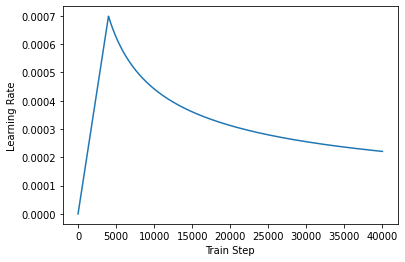

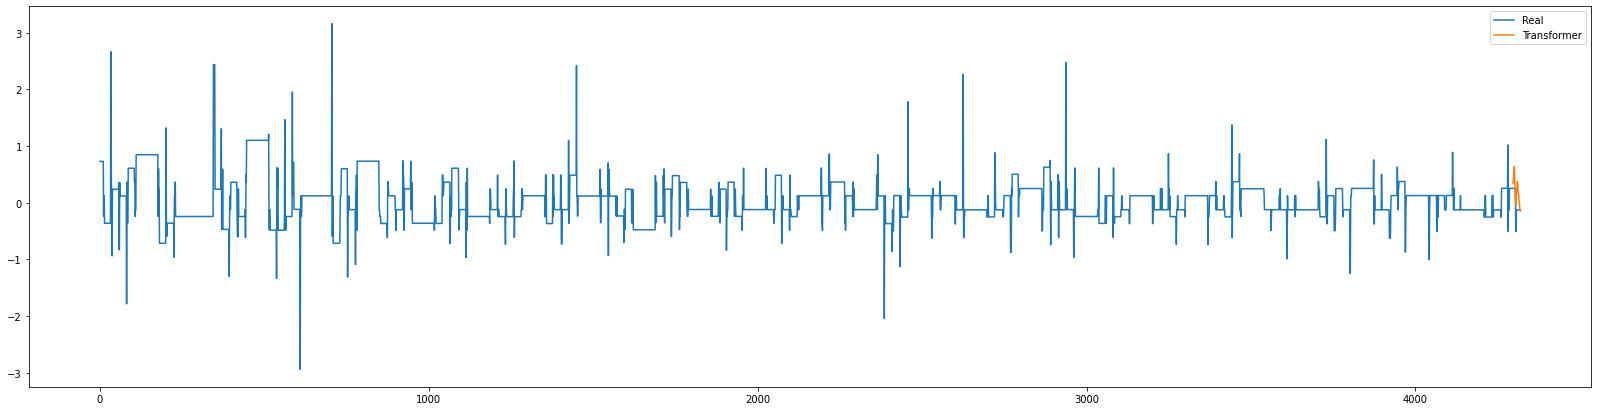

Transformer
----------------------------------------
MSE: 0.0891830325126648 |
MAE : 0.25430482625961304
Transformer 모델이 동작하는 시간 : 10.303718090057373



In [3]:
# informer, ARIMA, Prophet, LSTMa와는 다른 형식의 CSV를 사용한다.(Version2)

# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version2.csv', encoding='cp949')
df.head()

data_start_date = df.columns[1]
data_end_date = df.columns[-1]

######################## CHECK #########################


from datetime import timedelta

pred_steps = 24*1+23
pred_length=timedelta(hours = pred_steps)

first_day = pd.to_datetime(data_start_date)
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day


train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)


enc_length = train_pred_start - first_day


train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

#np.log 1p 해준다.

date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values.astype(np.float32)

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1)
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))

    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))    
    
    return series_array

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)


encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)


encoder_input_val_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_val_data, encode_series_mean = transform_series_encode(encoder_input_val_data)

decoder_target_val_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_val_data = transform_series_decode(decoder_target_val_data, encode_series_mean)

!pip install tensorflow_datasets

import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_target_data))
val_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_val_data, decoder_target_val_data))

### position
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

# Masking
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions so that we can add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 4))
temp = create_look_ahead_mask(x.shape[1])

# Scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.
  
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth)
        mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_v, depth)

    return output, attention_weights


# Multi Head Attention

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v) # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size) #(batch_size, num_head, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_v, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_v, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_v, d_model)
        
        return output, attention_weights
    

# Point wise feed forward network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


# Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)
        
        return out2


# Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
                                            
    def call(self, x, enc_output, training,
            look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

# Encoder

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000,
                rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding
        x = self.embedding(x)
        # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x


# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training,
                look_ahead_mask, padding_mask):
        
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                  look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        
        
        return x, attention_weights
    


class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, out_dim, max_len=5000,
                rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                              max_len, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               max_len, rate)
        
        self.final_layer = tf.keras.layers.Dense(out_dim)
        
    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights


# Set hyperparameters
# 트랜스포머 기준으로 바꿔볼까? 
# d_model – the number of expected features in the encoder/decoder inputs (default=512).
# nhead – the number of heads in the multiheadattention models (default=8).
# num_encoder_layers – the number of sub-encoder-layers in the encoder & decoder (default=6).
# num_decoder_layers – the number of sub-decoder-layers in the decoder (default=6).
# dff(dim_feedforward) – the dimension of the feedforward network model (default=2048).
# dropout – the dropout value (default=0.1).


num_layers = 1
d_model = 64
dff = 256
num_heads = 4

dropout_rate = 0.1
input_sequence_length = 4320-(24*1+23) # Length of the sequence used by the encoder
target_sequence_length = 24*1+23 # Length of the sequence predicted by the decoder
batch_size = 2**11

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Optimizizer
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(64)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and metrics
loss_object = tf.keras.losses.MeanAbsoluteError()

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name='train_loss')
#train_accuracy = tf.keras.metrics.mean_absolute_error()

test_loss = tf.keras.metrics.Mean(name='test_loss')

# Training and checkpoint
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          out_dim=1, rate=dropout_rate)

def create_masks(inp, tar):
    inp = inp.reshape()
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

# check point
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    
# EPOCHS
EPOCHS=100

@tf.function
def train_step(inp, tar):
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
  
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    #train_accuracy(tar_real, predictions)

@tf.function
def test_step(inp, tar):

    last_inp = tf.expand_dims(inp[:,0,:],-1)

    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     False, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    test_loss(loss)

# Val_dataset을 돌려서 Val_prediction 구간을 예측한다

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    test_loss.reset_states()
    
    # validation:
    for (batch, (inp, tar)) in enumerate(val_dataset):
        #print(inp, tar)
        test_step(inp, tar)
        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    print ('Epoch {} Test Loss {:.4f}'.format(epoch + 1, 
                                                test_loss.result())) 
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    
MAX_LENGTH = target_sequence_length

def evaluate(inp):
    encoder_input = inp
    #print(encoder_input)
    output = tf.expand_dims(encoder_input[:,-1,:],-1)
    #print(output)
    
    for i in range(MAX_LENGTH):
        look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
        predictions, attention_weights = transformer(encoder_input, 
                                                     output, 
                                                     False, 
                                                     None, 
                                                     look_ahead_mask, 
                                                     None)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1)
        #print("pred:", predictions) #
        output = tf.concat([output, predictions], axis=1)
        #print(output)
        
    return tf.squeeze(output, axis=0), attention_weights

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

encode_series = encoder_input_val_data[0:1,:,:] 
#print(encode_series)

pred_series, _ = evaluate(encode_series)
pred_series = np.array([pred_series])
encode_series_24 = encode_series.reshape(-1,1)
pred_series_24 = pred_series.reshape(-1,1)[1:,:]   
target_series_24 = decoder_target_val_data[0,:,:1].reshape(-1,1) 

encode_series_tail_24 = np.concatenate([encode_series_24[-1000:],target_series_24[:1]])
x_encode_24 = encode_series_tail_24.shape[0]


# Transformer 시간 측정 끝

Transformer_24 = time.time() - time0

# 실제와 가격차이가 어떻게 나는지 비교해서 보정한다.

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')
df = df.drop(df.columns[0], axis=1)
df.columns = ["ds","y"]
df.head()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df["y"].iloc[1:], label="Real")

plt.plot(range(4320-24*1,4320),pred_series_24[:24*1+23-23]+0.02294, label="Transformer")

plt.legend()
plt.show()

print('Transformer')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nTransformer 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(target_series_24+0.02294, pred_series_24[:24*1+23-23]+0.02294), mean_absolute_error(target_series_24+0.02294, pred_series_24[:24*1+23-23]+0.02294),Transformer_24))


# Predict Sequence length : 48H

Latest checkpoint restored!!
Epoch 1 Test Loss 0.3893
Time taken for 1 epoch: 2.069218158721924 secs

Epoch 2 Test Loss 0.3882
Time taken for 1 epoch: 0.031691551208496094 secs

Epoch 3 Test Loss 0.3919
Time taken for 1 epoch: 0.031003236770629883 secs

Epoch 4 Test Loss 0.3889
Time taken for 1 epoch: 0.03100419044494629 secs

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-41
Epoch 5 Test Loss 0.3694
Time taken for 1 epoch: 0.09815549850463867 secs

Epoch 6 Test Loss 0.3445
Time taken for 1 epoch: 0.028944730758666992 secs

Epoch 7 Test Loss 0.3304
Time taken for 1 epoch: 0.029729843139648438 secs

Epoch 8 Test Loss 0.3291
Time taken for 1 epoch: 0.029178142547607422 secs

Epoch 9 Test Loss 0.3215
Time taken for 1 epoch: 0.02908921241760254 secs

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-42
Epoch 10 Test Loss 0.3053
Time taken for 1 epoch: 0.0838935375213623 secs

Epoch 11 Test Loss 0.2861
Time taken for 1 epoch: 0.03019881248474121 secs

Epoch 12 Test Loss 

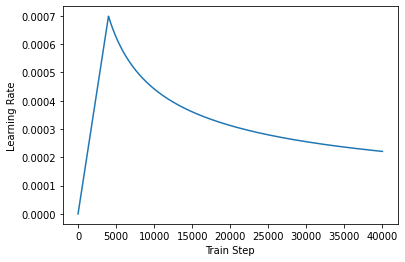

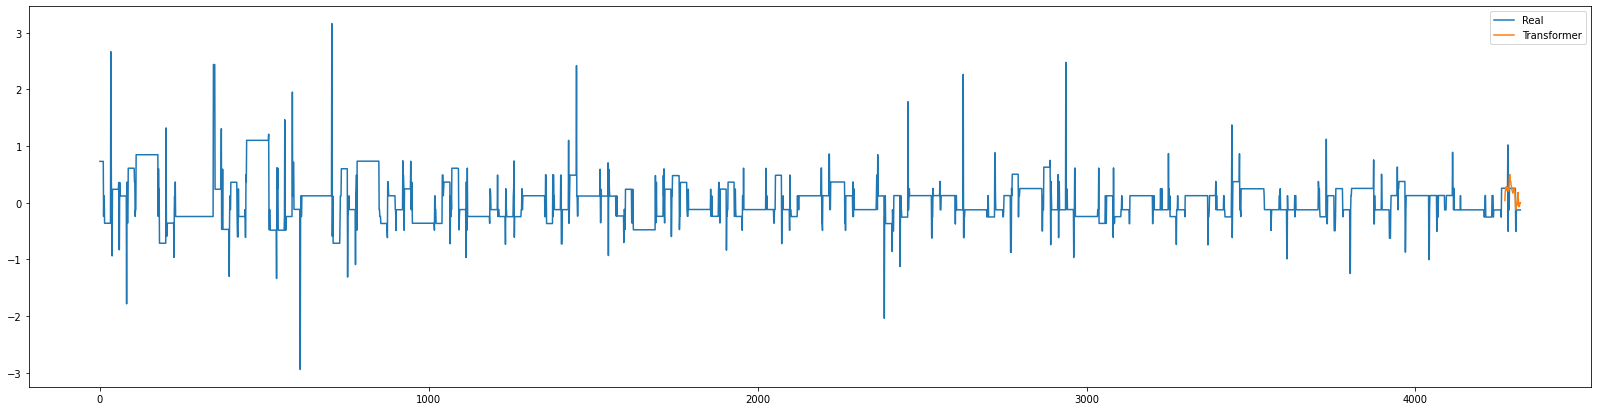

Transformer
----------------------------------------
MSE: 0.05097472667694092 |
MAE : 0.14856605231761932
Transformer 모델이 동작하는 시간 : 11.17192530632019



In [4]:
# informer, ARIMA, Prophet, LSTMa와는 다른 형식의 CSV를 사용한다.(Version2)

# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version2.csv', encoding='cp949')
df.head()

data_start_date = df.columns[1]
data_end_date = df.columns[-1]

######################## CHECK #########################


from datetime import timedelta

pred_steps = 24*2+23
pred_length=timedelta(hours = pred_steps)

first_day = pd.to_datetime(data_start_date)
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day


train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)


enc_length = train_pred_start - first_day


train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

#np.log 1p 해준다.

date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values.astype(np.float32)

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1)
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))

    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))    
    
    return series_array

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)


encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)


encoder_input_val_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_val_data, encode_series_mean = transform_series_encode(encoder_input_val_data)

decoder_target_val_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_val_data = transform_series_decode(decoder_target_val_data, encode_series_mean)

!pip install tensorflow_datasets

import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_target_data))
val_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_val_data, decoder_target_val_data))

### position
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

# Masking
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions so that we can add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 4))
temp = create_look_ahead_mask(x.shape[1])

# Scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.
  
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth)
        mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_v, depth)

    return output, attention_weights


# Multi Head Attention

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v) # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size) #(batch_size, num_head, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_v, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_v, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_v, d_model)
        
        return output, attention_weights
    

# Point wise feed forward network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


# Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)
        
        return out2


# Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
                                            
    def call(self, x, enc_output, training,
            look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

# Encoder

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000,
                rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding
        x = self.embedding(x)
        # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x


# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training,
                look_ahead_mask, padding_mask):
        
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                  look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        
        
        return x, attention_weights
    


class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, out_dim, max_len=5000,
                rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                              max_len, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               max_len, rate)
        
        self.final_layer = tf.keras.layers.Dense(out_dim)
        
    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights


# Set hyperparameters
# 트랜스포머 기준으로 바꿔볼까? 
# d_model – the number of expected features in the encoder/decoder inputs (default=512).
# nhead – the number of heads in the multiheadattention models (default=8).
# num_encoder_layers – the number of sub-encoder-layers in the encoder & decoder (default=6).
# num_decoder_layers – the number of sub-decoder-layers in the decoder (default=6).
# dff(dim_feedforward) – the dimension of the feedforward network model (default=2048).
# dropout – the dropout value (default=0.1).


num_layers = 1
d_model = 64
dff = 256
num_heads = 4

dropout_rate = 0.1
input_sequence_length = 4320-(24*2+23) # Length of the sequence used by the encoder
target_sequence_length = 24*2+23 # Length of the sequence predicted by the decoder
batch_size = 2**11

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Optimizizer
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(64)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and metrics
loss_object = tf.keras.losses.MeanAbsoluteError()

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name='train_loss')
#train_accuracy = tf.keras.metrics.mean_absolute_error()

test_loss = tf.keras.metrics.Mean(name='test_loss')

# Training and checkpoint
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          out_dim=1, rate=dropout_rate)

def create_masks(inp, tar):
    inp = inp.reshape()
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

# check point
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    
# EPOCHS
EPOCHS=100

@tf.function
def train_step(inp, tar):
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
  
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    #train_accuracy(tar_real, predictions)

@tf.function
def test_step(inp, tar):

    last_inp = tf.expand_dims(inp[:,0,:],-1)

    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     False, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    test_loss(loss)

# Val_dataset을 돌려서 Val_prediction 구간을 예측한다

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    test_loss.reset_states()
    
    # validation:
    for (batch, (inp, tar)) in enumerate(val_dataset):
        #print(inp, tar)
        test_step(inp, tar)
        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    print ('Epoch {} Test Loss {:.4f}'.format(epoch + 1, 
                                                test_loss.result())) 
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    
MAX_LENGTH = target_sequence_length

def evaluate(inp):
    encoder_input = inp
    #print(encoder_input)
    output = tf.expand_dims(encoder_input[:,-1,:],-1)
    #print(output)
    
    for i in range(MAX_LENGTH):
        look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
        predictions, attention_weights = transformer(encoder_input, 
                                                     output, 
                                                     False, 
                                                     None, 
                                                     look_ahead_mask, 
                                                     None)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1)
        #print("pred:", predictions) #
        output = tf.concat([output, predictions], axis=1)
        #print(output)
        
    return tf.squeeze(output, axis=0), attention_weights

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

encode_series = encoder_input_val_data[0:1,:,:] 
#print(encode_series)

pred_series, _ = evaluate(encode_series)
pred_series = np.array([pred_series])
encode_series_48 = encode_series.reshape(-1,1)
pred_series_48 = pred_series.reshape(-1,1)[1:,:]   
target_series_48 = decoder_target_val_data[0,:,:1].reshape(-1,1) 

encode_series_tail_48 = np.concatenate([encode_series_48[-1000:],target_series_48[:1]])
x_encode_48 = encode_series_tail_48.shape[0]


# Transformer 시간 측정 끝

Transformer_48 = time.time() - time0

# 실제와 가격차이가 어떻게 나는지 비교해서 보정한다.

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')
df = df.drop(df.columns[0], axis=1)
df.columns = ["ds","y"]
df.head()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df["y"].iloc[1:], label="Real")

plt.plot(range(4320-24*2,4320),pred_series_48[:24*2+23-23]+0.02294, label="Transformer")

plt.legend()
plt.show()

print('Transformer')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nTransformer 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(target_series_48+0.02294, pred_series_48[:24*2+23-23]+0.02294), mean_absolute_error(target_series_48+0.02294, pred_series_48[:24*2+23-23]+0.02294),Transformer_48))

# Predict Sequence length : 192H

Latest checkpoint restored!!
Epoch 1 Test Loss 0.5878
Time taken for 1 epoch: 2.001323938369751 secs

Epoch 2 Test Loss 0.5535
Time taken for 1 epoch: 0.03101491928100586 secs

Epoch 3 Test Loss 0.5699
Time taken for 1 epoch: 0.03018665313720703 secs

Epoch 4 Test Loss 0.5480
Time taken for 1 epoch: 0.03088521957397461 secs

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-61
Epoch 5 Test Loss 0.5005
Time taken for 1 epoch: 0.0962982177734375 secs

Epoch 6 Test Loss 0.5013
Time taken for 1 epoch: 0.02991771697998047 secs

Epoch 7 Test Loss 0.4843
Time taken for 1 epoch: 0.030842304229736328 secs

Epoch 8 Test Loss 0.4478
Time taken for 1 epoch: 0.02854323387145996 secs

Epoch 9 Test Loss 0.4412
Time taken for 1 epoch: 0.029221773147583008 secs

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-62
Epoch 10 Test Loss 0.4436
Time taken for 1 epoch: 0.09132790565490723 secs

Epoch 11 Test Loss 0.4245
Time taken for 1 epoch: 0.02895188331604004 secs

Epoch 12 Test Loss 0.4

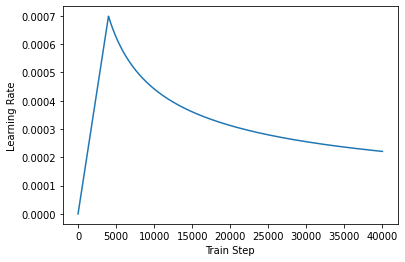

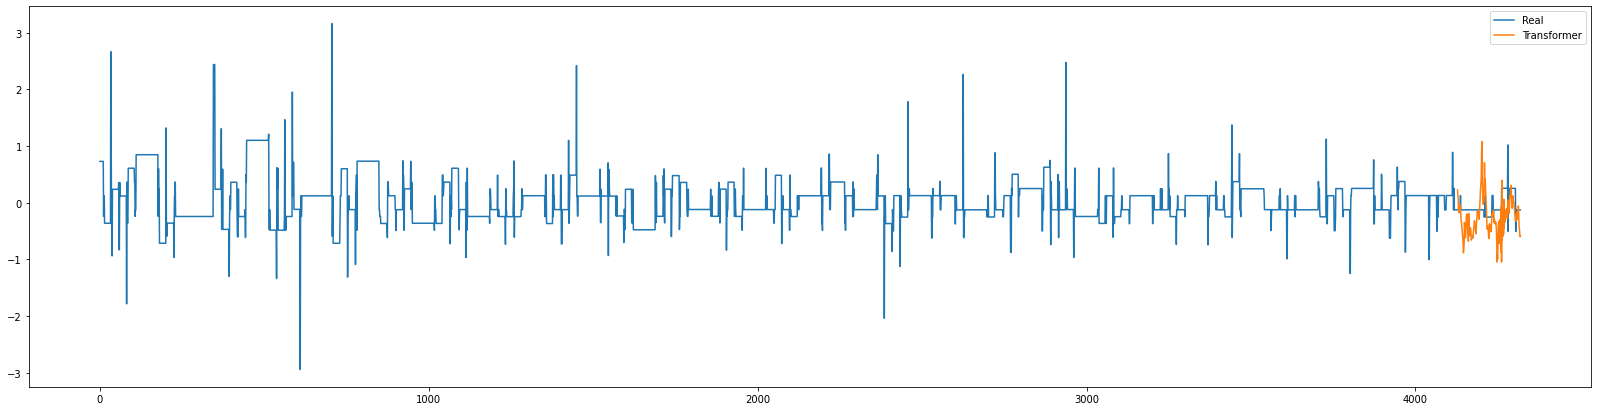

Transformer
----------------------------------------
MSE: 0.15879711508750916 |
MAE : 0.3237058222293854
Transformer 모델이 동작하는 시간 : 15.653088331222534



In [5]:
# informer, ARIMA, Prophet, LSTMa와는 다른 형식의 CSV를 사용한다.(Version2)

# LSTMa 시간 측정 시작

import time

time0 = time.time() 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version2.csv', encoding='cp949')
df.head()

data_start_date = df.columns[1]
data_end_date = df.columns[-1]

######################## CHECK #########################


from datetime import timedelta

pred_steps = 24*8+23
pred_length=timedelta(hours = pred_steps)

first_day = pd.to_datetime(data_start_date)
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day


train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)


enc_length = train_pred_start - first_day


train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

#np.log 1p 해준다.

date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values.astype(np.float32)

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1)
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))

    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))    
    
    return series_array

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)


encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)


encoder_input_val_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_val_data, encode_series_mean = transform_series_encode(encoder_input_val_data)

decoder_target_val_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_val_data = transform_series_decode(decoder_target_val_data, encode_series_mean)

!pip install tensorflow_datasets

import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_target_data))
val_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_val_data, decoder_target_val_data))

### position
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

# Masking
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions so that we can add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 4))
temp = create_look_ahead_mask(x.shape[1])

# Scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.
  
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth)
        mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_v, depth)

    return output, attention_weights


# Multi Head Attention

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v) # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size) #(batch_size, num_head, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_v, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_v, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_v, d_model)
        
        return output, attention_weights
    

# Point wise feed forward network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


# Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)
        
        return out2


# Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
                                            
    def call(self, x, enc_output, training,
            look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

# Encoder

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000,
                rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding
        x = self.embedding(x)
        # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x


# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training,
                look_ahead_mask, padding_mask):
        
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                  look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        
        
        return x, attention_weights
    


class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, out_dim, max_len=5000,
                rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                              max_len, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               max_len, rate)
        
        self.final_layer = tf.keras.layers.Dense(out_dim)
        
    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights


# Set hyperparameters
# 트랜스포머 기준으로 바꿔볼까? 
# d_model – the number of expected features in the encoder/decoder inputs (default=512).
# nhead – the number of heads in the multiheadattention models (default=8).
# num_encoder_layers – the number of sub-encoder-layers in the encoder & decoder (default=6).
# num_decoder_layers – the number of sub-decoder-layers in the decoder (default=6).
# dff(dim_feedforward) – the dimension of the feedforward network model (default=2048).
# dropout – the dropout value (default=0.1).


num_layers = 1
d_model = 64
dff = 256
num_heads = 4

dropout_rate = 0.1
input_sequence_length = 4320-(24*8+23) # Length of the sequence used by the encoder
target_sequence_length = 24*8+23 # Length of the sequence predicted by the decoder
batch_size = 2**11

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Optimizizer
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(64)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and metrics
loss_object = tf.keras.losses.MeanAbsoluteError()

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name='train_loss')
#train_accuracy = tf.keras.metrics.mean_absolute_error()

test_loss = tf.keras.metrics.Mean(name='test_loss')

# Training and checkpoint
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          out_dim=1, rate=dropout_rate)

def create_masks(inp, tar):
    inp = inp.reshape()
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

# check point
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    
# EPOCHS
EPOCHS=100

@tf.function
def train_step(inp, tar):
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
  
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    #train_accuracy(tar_real, predictions)

@tf.function
def test_step(inp, tar):

    last_inp = tf.expand_dims(inp[:,0,:],-1)

    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     False, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    test_loss(loss)

# Val_dataset을 돌려서 Val_prediction 구간을 예측한다

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    test_loss.reset_states()
    
    # validation:
    for (batch, (inp, tar)) in enumerate(val_dataset):
        #print(inp, tar)
        test_step(inp, tar)
        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    print ('Epoch {} Test Loss {:.4f}'.format(epoch + 1, 
                                                test_loss.result())) 
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    
MAX_LENGTH = target_sequence_length

def evaluate(inp):
    encoder_input = inp
    #print(encoder_input)
    output = tf.expand_dims(encoder_input[:,-1,:],-1)
    #print(output)
    
    for i in range(MAX_LENGTH):
        look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
        predictions, attention_weights = transformer(encoder_input, 
                                                     output, 
                                                     False, 
                                                     None, 
                                                     look_ahead_mask, 
                                                     None)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1)
        #print("pred:", predictions) #
        output = tf.concat([output, predictions], axis=1)
        #print(output)
        
    return tf.squeeze(output, axis=0), attention_weights

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

encode_series = encoder_input_val_data[0:1,:,:] 
#print(encode_series)

pred_series, _ = evaluate(encode_series)
pred_series = np.array([pred_series])
encode_series_192 = encode_series.reshape(-1,1)
pred_series_192 = pred_series.reshape(-1,1)[1:,:]   
target_series_192 = decoder_target_val_data[0,:,:1].reshape(-1,1) 

encode_series_tail_192 = np.concatenate([encode_series_192[-1000:],target_series_192[:1]])
x_encode_192 = encode_series_tail_192.shape[0]


# Transformer 시간 측정 끝

Transformer_192 = time.time() - time0

# 실제와 가격차이가 어떻게 나는지 비교해서 보정한다.

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')
df = df.drop(df.columns[0], axis=1)
df.columns = ["ds","y"]
df.head()

plt.figure(figsize=(28,7))
plt.plot(range(0,4320), df["y"].iloc[1:], label="Real")

plt.plot(range(4320-24*8,4320),pred_series_192[:24*8+23-23]+0.02294, label="Transformer")

plt.legend()
plt.show()

print('Transformer')
print('-' * 40)
print('MSE: {} |\nMAE : {}\nTransformer 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(target_series_192+0.02294, pred_series_192[:24*8+23-23]+0.02294), mean_absolute_error(target_series_192+0.02294, pred_series_192[:24*8+23-23]+0.02294),Transformer_192))

In [6]:
print('Transformer_12')
print('MSE: {} |\nMAE : {}\nTransformer 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(target_series_12+0.02294, pred_series_12[:12+23-23]+0.02294), mean_absolute_error(target_series_12+0.02294, pred_series_12[:12+23-23]+0.02294),Transformer_12))
print('-' * 40)
print('Transformer_24')
print('MSE: {} |\nMAE : {}\nTransformer 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(target_series_24+0.02294, pred_series_24[:24*1+23-23]+0.02294), mean_absolute_error(target_series_24+0.02294, pred_series_24[:24*1+23-23]+0.02294),Transformer_24))
print('-' * 40)
print('Transformer_48')
print('MSE: {} |\nMAE : {}\nTransformer 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(target_series_48+0.02294, pred_series_48[:24*2+23-23]+0.02294), mean_absolute_error(target_series_48+0.02294, pred_series_48[:24*2+23-23]+0.02294),Transformer_48))
print('-' * 40)
print('Transformer_192')
print('MSE: {} |\nMAE : {}\nTransformer 모델이 동작하는 시간 : {}\n'.format(mean_squared_error(target_series_192+0.02294, pred_series_192[:24*8+23-23]+0.02294), mean_absolute_error(target_series_192+0.02294, pred_series_192[:24*8+23-23]+0.02294),Transformer_192))

Transformer_12
MSE: 0.08130421489477158 |
MAE : 0.22178857028484344
Transformer 모델이 동작하는 시간 : 19.863006114959717

----------------------------------------
Transformer_24
MSE: 0.0891830325126648 |
MAE : 0.25430482625961304
Transformer 모델이 동작하는 시간 : 10.303718090057373

----------------------------------------
Transformer_48
MSE: 0.05097472667694092 |
MAE : 0.14856605231761932
Transformer 모델이 동작하는 시간 : 11.17192530632019

----------------------------------------
Transformer_192
MSE: 0.15879711508750916 |
MAE : 0.3237058222293854
Transformer 모델이 동작하는 시간 : 15.653088331222534

